In [25]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Simple U-NET
def unetmodel(input_shape, dropout=0.2, batchnorm=True):    
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers   
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()        
    return model

    
#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

#Res-UNET
def residualunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_conv1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    dn_pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv1)

    dn_conv2 = res_conv_block(dn_pool1, kernelsize, filters[1], dropout, batchnorm)
    dn_pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv2)

    dn_conv3 = res_conv_block(dn_pool2, kernelsize, filters[2], dropout, batchnorm)
    dn_pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv3)

    dn_conv4 = res_conv_block(dn_pool3, kernelsize, filters[3], dropout, batchnorm)
    dn_pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv4)

    dn_conv5 = res_conv_block(dn_pool4, kernelsize, filters[4], dropout, batchnorm)
   
    # upsampling layers
    up_conv6 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_conv5)
    up_conv6 = layers.concatenate([up_conv6, dn_conv4], axis=3)
    up_conv6 = res_conv_block(up_conv6, kernelsize, filters[3], dropout, batchnorm)

    up_conv7 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv6)
    up_conv7 = layers.concatenate([up_conv7, dn_conv3], axis=3)
    up_conv7 = res_conv_block(up_conv7, kernelsize, filters[2], dropout, batchnorm)

    up_conv8 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv7)
    up_conv8 = layers.concatenate([up_conv8, dn_conv2], axis=3)
    up_conv8 = res_conv_block(up_conv8, kernelsize, filters[1], dropout, batchnorm)

    up_conv9 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv8)
    up_conv9 = layers.concatenate([up_conv9, dn_conv1], axis=3)
    up_conv9 = res_conv_block(up_conv9, kernelsize, filters[0], dropout, batchnorm)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv9)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final) 
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

#Residual-Attention UNET (RA-UNET)
def residual_attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    
    
    # Downsampling layers
    dn_1 = res_conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = res_conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = res_conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = res_conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = res_conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = res_conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = res_conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = res_conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = res_conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary() 
    return model

In [26]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)     
   return np.mean(IoU) 

In [27]:
!pip install patchify


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 512, 512, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
50/50 [==============================] - 37s 445ms/step - loss: -8.1440e-04 - accuracy: 0.5523 - IoU_coef: 8.1440e-04 - val_loss: -7.7751e-04 - val_accuracy: 0.6039 - val_IoU_coef: 7.7609e-04
Epoch 2/100
50/50 [==============================] - 21s 418ms/step - loss: -8.9484e-04 - accuracy: 0.5992 - IoU_coef: 8.9484e-04 - val_loss: -8.4555e-04 - val_accuracy: 0.7719 - val_IoU_coef: 8.4830e-04
Epoch 3/100
50/50 [==============================] - 21s 418ms/step - loss: -9.4815e-04 - accuracy: 0.6330 - IoU_coef: 9.4815e-04 - val_loss: -7.2650e-04 - val_accuracy: 0.8047 - val_IoU_coef: 7.3175e-04
Epoch 4/100
50/50 [==============================] - 21s 418ms/step - loss: -9.8881e-04 - accuracy: 0.6563 - IoU_coef: 9.8881e-04 - val_loss: -8.2834e-04 - val_accuracy: 0.7937 - val_IoU_coef: 8.3204e-04
Epoch 5/100
50/50 [==============================] - 21s 418ms/step - loss: -0.0010 - accuracy: 0.6737 - IoU_coef: 0.0010 - val_loss: -8.5491e-04 - val_accuracy: 0.6373 - val_IoU_coef:

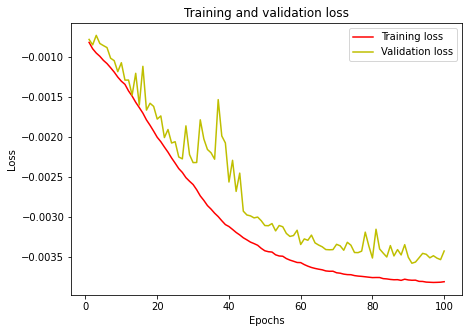

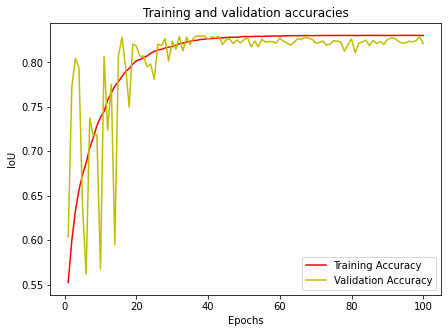

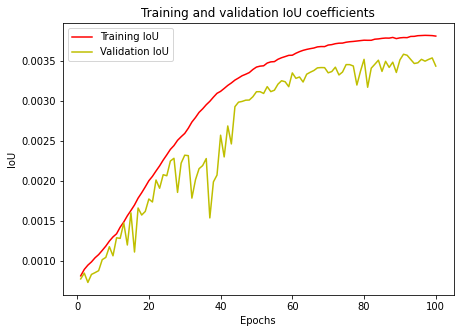

In [28]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
np.random.seed(0) 


#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized


path1 = '/content/drive/MyDrive/training/images' #training images directory
path2 = '/content/drive/MyDrive/training/masks' #training masks directory

image_dataset = []
mask_dataset = [] 

patch_size = 512

images = sorted(os.listdir(path1)) 

for i, image_name in enumerate(images):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       
       image = image[:,:,1] #selecting green channel
       image = clahe_equalized(image) #applying CLAHE
       

       SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
       SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
       patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
       for i in range(patches_img.shape[0]):
           for j in range(patches_img.shape[1]):                        
               single_patch_img = patches_img[i,j,:,:]                 
               single_patch_img = (single_patch_img.astype('float32')) / 255.                    
               image_dataset.append(single_patch_img)

masks = sorted(os.listdir(path2))  
for i, mask_name in enumerate(masks):  
    if mask_name.endswith(".jpg"):                  
        mask = skimage.io.imread(path2+"/"+mask_name,as_gray=True)   #Read masks
        
        
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #getting size multiple of patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #getting size multiple of patch size
        mask = Image.fromarray(mask)        
        mask = mask.resize((512, 512))  #resize image
        mask = np.array(mask)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):                            
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask.astype('float32'))/255. 
                mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)


#importing models

from tensorflow.keras.optimizers import Adam


IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])

#model = residualunet(input_shape)
#model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
#model = attentionunet(input_shape)
#model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
#model = residual_attentionunet(input_shape)
#model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])


#splitting data into 70-30 ratio to validate training performance
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=0)

#train model
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 16,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=100)

#training-validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#training-validation IoU curve
iou_coef = history.history['IoU_coef']
val_iou_coef = history.history['val_IoU_coef']
plt.figure(figsize=(7,5))
plt.plot(epochs, iou_coef, 'r', label='Training IoU')
plt.plot(epochs, val_iou_coef, 'y', label='Validation IoU')
plt.title('Training and validation IoU coefficients')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#save model
#model.save('/content/drive/MyDrive/training/retina_Unet_150epochs.hdf5')

In [29]:
model.save('model-unet.h5')

In [36]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
np.random.seed(0)

# CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

patch_size = 512

#loading model architectures

from tensorflow.keras.optimizers import Adam


IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape) #/residualunet(input_shape)/attentionunet(input_shape)/attention_residualunet(input_shape) 
model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
model.load_weights('/content/model-unet.h5') #loading weights


path1 = '/content/drive/MyDrive/training/images/'    #test dataset images directory path
path2 = '/content/drive/MyDrive/training/masks/'     #test dataset mask directory path


from sklearn.metrics import jaccard_score,confusion_matrix

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []

testimages = sorted(os.listdir(path1))
testmasks =  sorted(os.listdir(path2))

for idx, image_name in enumerate(testimages):  
   if image_name.endswith(".jpg"):  
      predicted_patches = []
      test_img = skimage.io.imread(path1+"/"+image_name)
     
      test = test_img[:,:,1] #selecting green channel
      test = clahe_equalized(test) #applying CLAHE
      SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
      SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
      test = cv2.resize(test, (SIZE_X, SIZE_Y))
      testimg.append(test)           
      test = np.array(test)

      patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

      for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                  single_patch = patches[i,j,:,:]
                  single_patch_norm = (single_patch.astype('float32')) / 255.
                  single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
                  single_patch_input = np.expand_dims(single_patch_norm, 0)
                  single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
                  predicted_patches.append(single_patch_prediction)
      predicted_patches = np.array(predicted_patches)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
      reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
      prediction.append(reconstructed_image) 

      groundtruth=[]
      groundtruth = skimage.io.imread(path2+'/'+testmasks[idx]) #reading mask of the test img      
      SIZE_X = (groundtruth.shape[1]//patch_size)*patch_size 
      SIZE_Y = (groundtruth.shape[0]//patch_size)*patch_size  
      groundtruth = cv2.resize(groundtruth, (SIZE_X, SIZE_Y))  
      ground_truth.append(groundtruth)

      y_true = groundtruth
      y_pred = reconstructed_image
      labels = [0, 1]
      IoU = []
      for label in labels:
          jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
          IoU.append(jaccard)
      IoU = np.mean(IoU) #jacard/IoU of single image
      global_IoU.append(IoU)

      cm=[]
      accuracy = []
      cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
      accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]) #accuracy of single image
      global_accuracy.append(accuracy)


avg_acc =  np.mean(global_accuracy)
mean_IoU = np.mean(global_IoU)

print('Average accuracy is',avg_acc)
print('mean IoU is',mean_IoU)






#prediction on single image
from datetime import datetime 
reconstructed_image = []
test_img = skimage.io.imread('/content/drive/MyDrive/DRIVE/test/images/01_test.tif') #test image

predicted_patches = []
start = datetime.now()   

test = test_img[:,:,1] #selecting green channel
test = clahe_equalized(test) #applying CLAHE
SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
test = cv2.resize(test, (SIZE_X, SIZE_Y))        
test = np.array(test)
patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) / 255.
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
          predicted_patches.append(single_patch_prediction)
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.subplot(121)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)
plt.subplot(122)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_image,cmap='gray')

plt.show()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 512, 512, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_114 (Batch  (None, 512, 512, 16  64         ['conv2d_114[0][0]']             
 Normalization)                 )                                                           

ValueError: ignored

Execution time:  0:00:00.067530


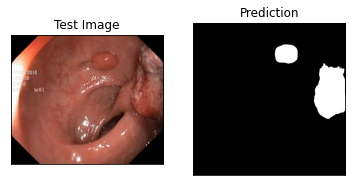

In [38]:
from datetime import datetime 
reconstructed_image = []
test_img = skimage.io.imread('/content/drive/MyDrive/training/images/cju0roawvklrq0799vmjorwfv.jpg') #test image

predicted_patches = []
start = datetime.now()   

test = test_img[:,:,1] #selecting green channel
test = clahe_equalized(test) #applying CLAHE
SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
test = cv2.resize(test, (SIZE_X, SIZE_Y))        
test = np.array(test)
patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) / 255.
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
          predicted_patches.append(single_patch_prediction)
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.subplot(121)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)
plt.subplot(122)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_image,cmap='gray')

plt.show()

In [ ]:
#checking segmentation results
import random
test_img_number = random.randint(0, len(testimg))
plt.figure(figsize=(20, 18))
plt.subplot(123)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(testimg[test_img_number])
plt.subplot(011)
plt.title('Ground Truth')
plt.xticks([])
plt.yticks([])
plt.imshow(ground_truth[test_img_number],cmap='gray')
plt.subplot(022)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(prediction[test_img_number],cmap='gray')

plt.show()